**Clustering time series con k-means e euclidean distance**

Per vedere il clustering con dtw, vedere il notebook: clustering_dtw.ipynb

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tqdm.notebook import tqdm
import numpy as np

metrics = "euclidean"

**Calcolo score (definito come numero di incidenti data la settimana e la città)** 

In [3]:
df = pd.read_csv("data/time_Series_Data.csv")
df['date'] = pd.to_datetime(df['date'])
df['year_month_week'] = df['date'].dt.to_period('W').dt.strftime('%Y-%m-%W')

weekly_data = df.groupby(['year_month_week', 'city']).size().reset_index(name='incident_count')
weekly_data.dropna(inplace=True)

**Vengono prese in considerazione solo le città che presentano un numero di settimane con incidenti che supera il 15% del totale delle settimane nell’arco dei 4 anni.**

In [4]:
selected_city = weekly_data.groupby(['city']).count()
selected_city = selected_city[selected_city.year_month_week >= 32].reset_index()['city']
df = weekly_data[weekly_data.city.isin(selected_city)]

df = df.pivot(index="city", columns="year_month_week", values="incident_count")
df.fillna(0, inplace=True)
df.head()

year_month_week,2014-01-00,2014-01-01,2014-01-02,2014-01-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,2014-03-08,2014-03-09,...,2017-10-43,2017-11-44,2017-11-45,2017-11-46,2017-11-47,2017-12-48,2017-12-49,2017-12-50,2017-12-51,2017-12-52
city,,,,,,,,,,,,,,,,,,,,,
Aberdeen,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
Abilene,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Aiken,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,1.0
Akron,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,4.0,1.0,1.0,4.0,2.0,2.0,3.0
Albany,1.0,0.0,5.0,0.0,2.0,0.0,2.0,1.0,1.0,0.0,...,4.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


**Esecuzione k-means con euclidean distance**

In [5]:
def k_means(x_cluster, max_k, timeSeriesKMeans_metric="dtw"):
    sse_list = list()
    sil_list = list()
    davies_list = list()
    for k in tqdm(range(2, max_k + 1), total=max_k - 1, desc="Dataframe {0}, iterating over {1} possible K values".format("cities", max_k)):
        kmeans_iter = TimeSeriesKMeans(n_clusters=k, metric=timeSeriesKMeans_metric, random_state=0)
        kmeans_iter.fit(x_cluster)
        
        davies_list.append(davies_bouldin_score(x_cluster, kmeans_iter.labels_))
        sil_list.append(silhouette_score(x_cluster, kmeans_iter.labels_))
        sse = kmeans_iter.inertia_
        sse_list.append(sse)

    return sse_list, sil_list, davies_list

def plot_indicators(sse_list, sil_list, davies_list):
    max_k = len(sse_list)+1
    _, axs = plt.subplots(3, 1, figsize=(10, 14));
    label_s = 10

    # SSE
    axs[0].plot(range(2, len(sse_list) + 2), sse_list)
    axs[0].set_ylabel('SSE', fontsize=16)
    axs[0].set_xlabel('K', fontsize=16)
    axs[0].tick_params(axis='both', which='major', labelsize=label_s)
    axs[0].set_xticks(range(2, max_k+1));

    # Silhouette
    axs[1].plot(range(2, len(sil_list) + 2), sil_list)
    axs[1].set_ylabel('Silhouette Score', fontsize=16)
    axs[1].set_xlabel('K', fontsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=label_s)
    axs[1].set_xticks(range(2,max_k+1));

    # Davies-Bouldin Score
    axs[2].plot(range(2, len(davies_list) + 2), davies_list)
    axs[2].set_ylabel('Davies-Bouldin Score', fontsize=16)
    axs[2].set_xlabel('K', fontsize=16)
    axs[2].tick_params(axis='both', which='major', labelsize=label_s)
    axs[2].set_xticks(range(2,max_k+1));

    axs[0].set_title("Indicatori clustering", fontsize=22)


In [6]:
sse, sil, davies_bouldin = k_means(df, 30, timeSeriesKMeans_metric=metrics)

Dataframe cities, iterating over 30 possible K values:   0%|          | 0/29 [00:00<?, ?it/s]

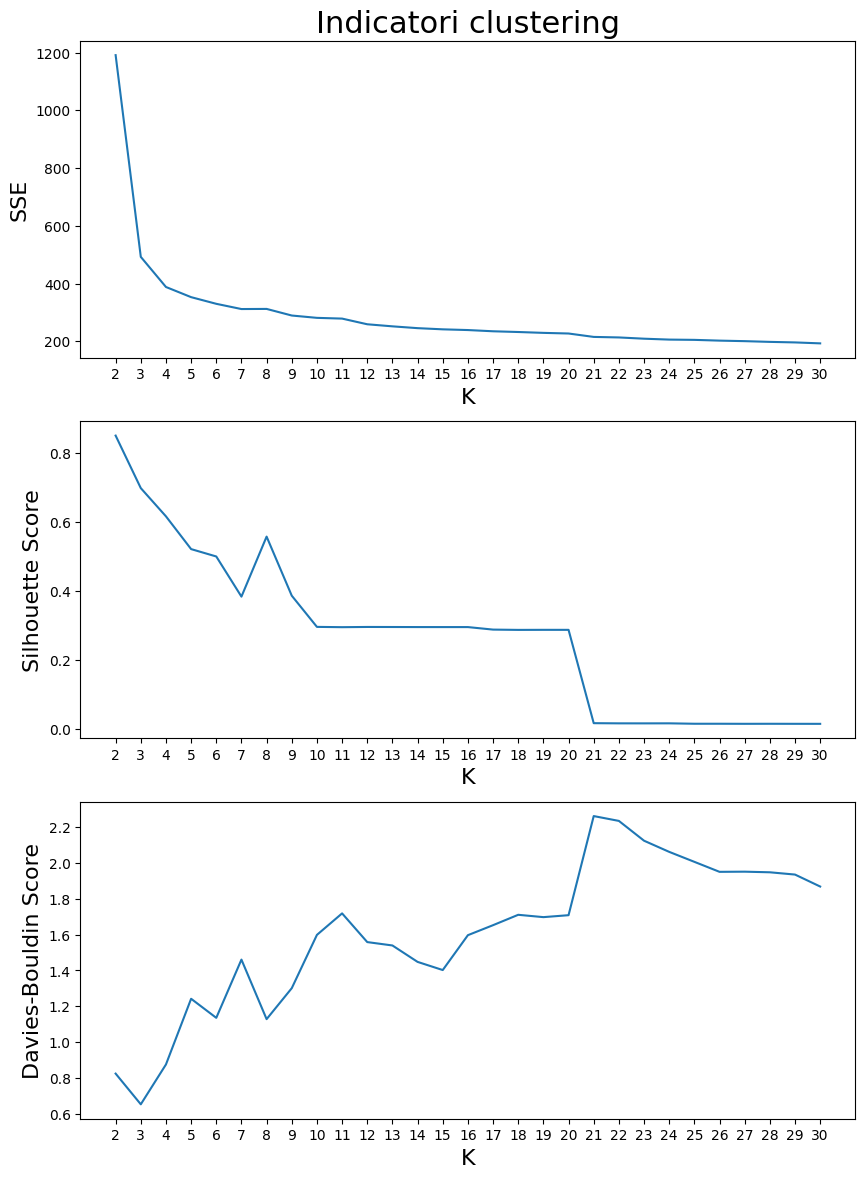

In [7]:
plot_indicators(sse, sil, davies_bouldin)

Usando l'elbow method su SSE si può osservare che il migliore valore è k=3. Inoltre, con k=3 si ha il valore minimo nel Davies-Bouldin Score e il secondo valore massimo in Silhouette score

**Interpretazione risultati con K=3**

In [8]:
k = 3 # best k value
kmeans = TimeSeriesKMeans(n_clusters=k, metric="euclidean")
kmeans.fit(df)
print("SSE:", sse[k-2], " - SILHOUETTE:", sil[k-2], " - DAVIES-BOULDIN:", davies_bouldin[k-2])

SSE: 492.5795207387169  - SILHOUETTE: 0.6973993367334794  - DAVIES-BOULDIN: 0.6528321713097187


**Numero di serie temporali per cluster**

In [9]:
# Ottieni le etichette dei cluster per ogni punto dati
labels = kmeans.labels_

# Calcola il conteggio per ogni cluster
unique, counts = np.unique(labels, return_counts=True)

# Crea un dizionario con i cluster come chiavi e i conteggi come valori
cluster_counts = dict(zip(unique, counts))

# Stampa il conteggio per ogni cluster
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} serie temporali")

Cluster 0: 521 serie temporali
Cluster 1: 1 serie temporali
Cluster 2: 49 serie temporali


**Plot serie temporali in base al cluster**

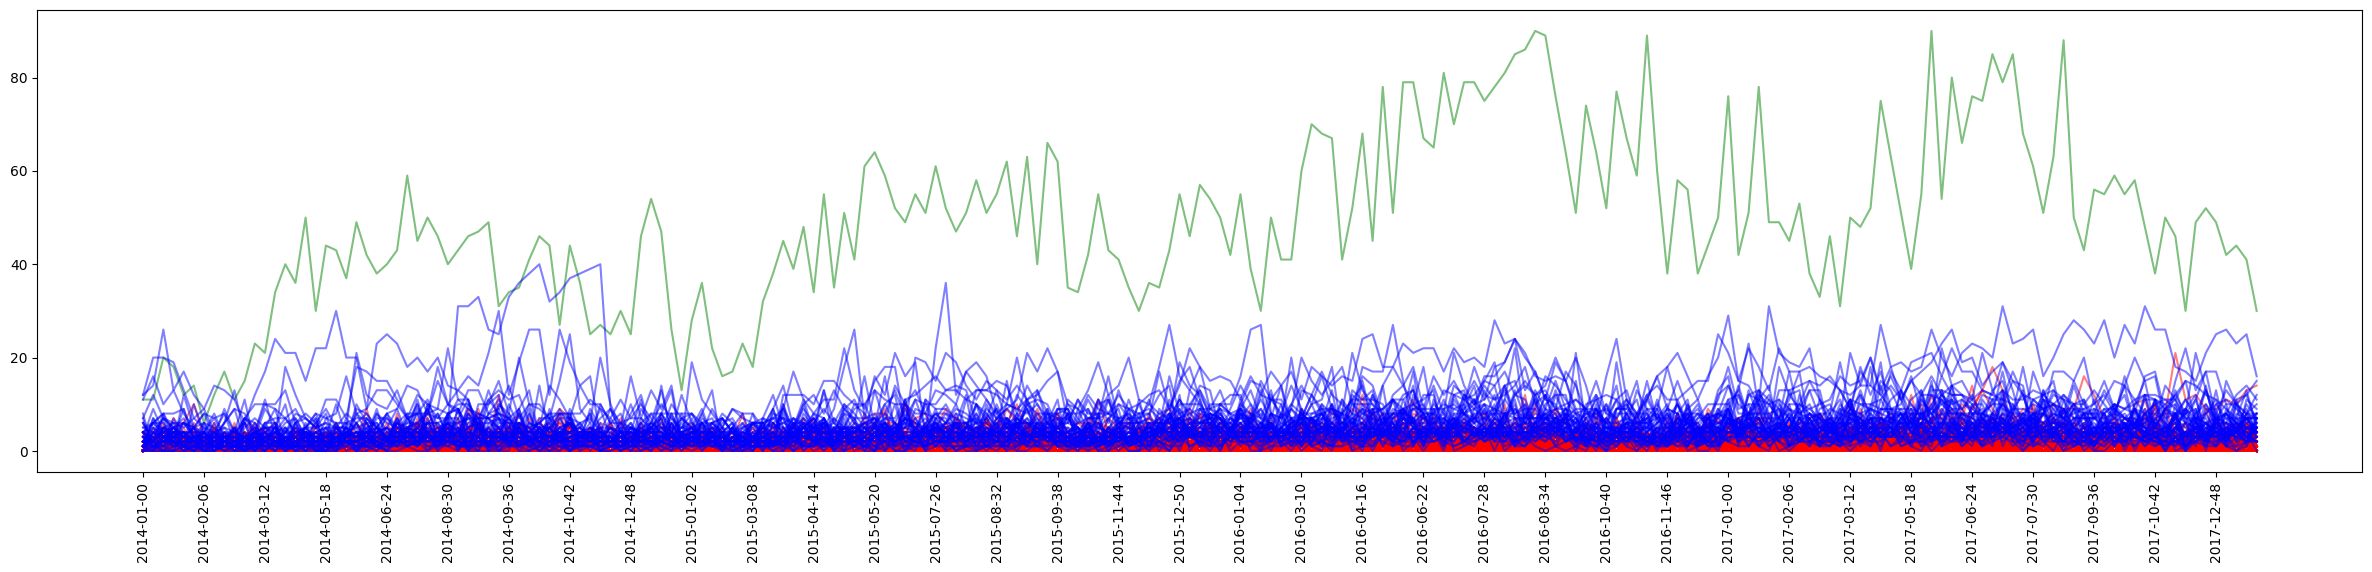

In [10]:
labels = kmeans.labels_

# Crea una lista di colori unici per ogni cluster
colors = ['red', 'green', 'blue']

plt.figure(figsize=(30,6))
for i, color in enumerate(colors):
    idx = np.where(labels == i)
    
    plt.plot(df.iloc[idx].T, color=color, alpha=0.5)

# Seleziona un sottoinsieme di etichette da mostrare
xticks = plt.xticks()[0]
num_xticks = len(xticks)
step = num_xticks // 30  # Mostra solo 10 etichette
plt.xticks(xticks[::step], rotation='vertical')  # Mostra ogni 'step' etichetta

# Mostra il grafico
plt.show()


**Distribuzione del numero di persone coinvolte in incidenti per cluster**

In [11]:
cluster_0 = df[labels == 0]
cluster_1 = df[labels == 1]
cluster_2 = df[labels == 2]

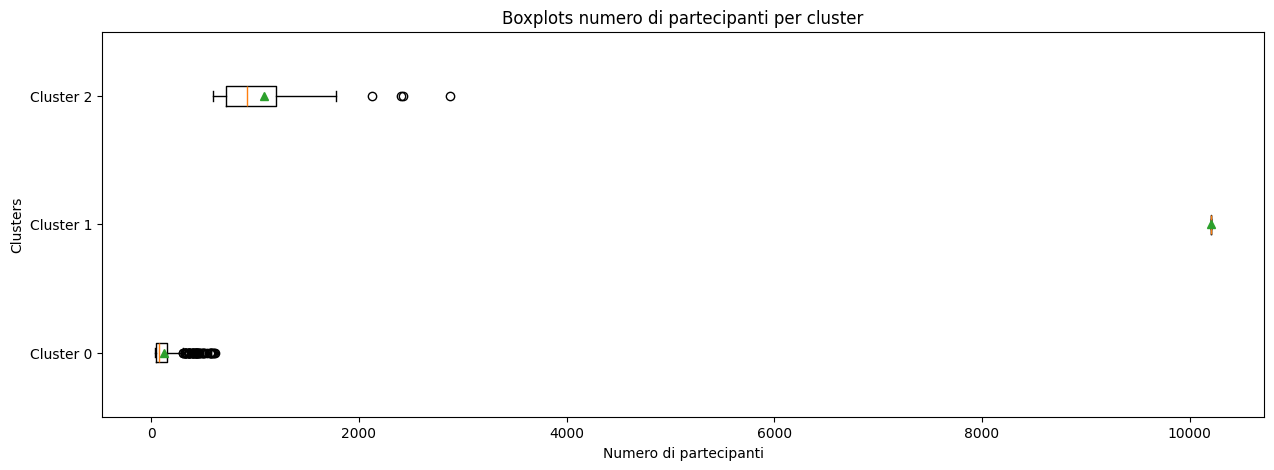

In [12]:
plt.figure(figsize=(15, 5))

positions = [1, 2, 3]

plt.boxplot(cluster_0.sum(axis=1), vert=False, showmeans=True, positions=[positions[0]], labels=["Cluster 0"])
plt.boxplot(cluster_1.sum(axis=1), vert=False, showmeans=True, positions=[positions[1]], labels=["Cluster 1"])
plt.boxplot(cluster_2.sum(axis=1), vert=False, showmeans=True, positions=[positions[2]], labels=["Cluster 2"])

plt.xlabel("Numero di partecipanti")
plt.ylabel("Clusters")
plt.title("Boxplots numero di partecipanti per cluster")
plt.show()

**Distribuzione del numero di settimane in cui è avvenuto almeno un incidente per cluster**

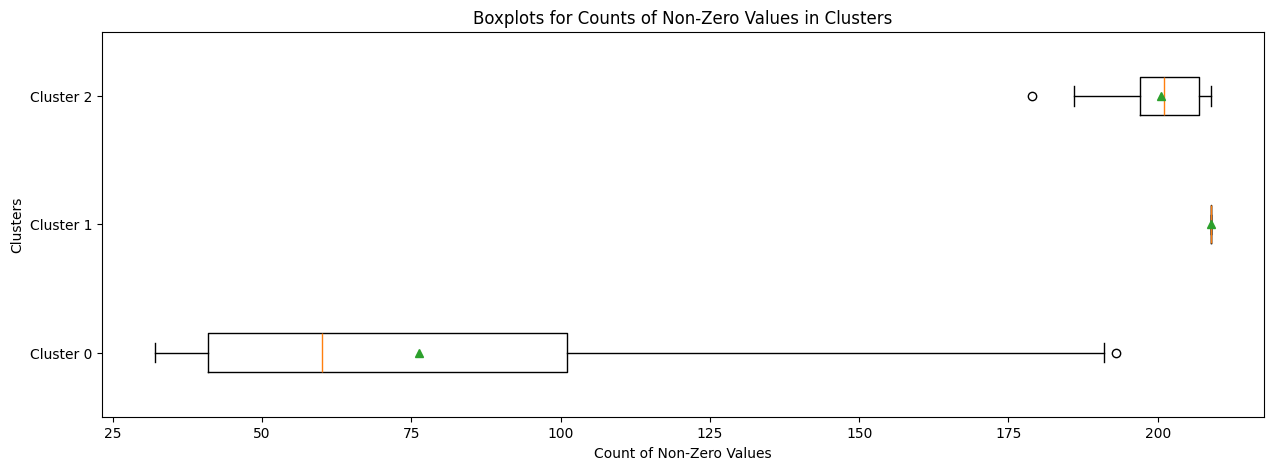

In [13]:
plt.figure(figsize=(15, 5))

counts_cluster_0 = cluster_0.apply(lambda row: (row != 0).sum(), axis=1)
counts_cluster_1 = cluster_1.apply(lambda row: (row != 0).sum(), axis=1)
counts_cluster_2 = cluster_2.apply(lambda row: (row != 0).sum(), axis=1)

positions = [1, 2, 3]
plt.boxplot([counts_cluster_0, counts_cluster_1, counts_cluster_2], vert=False, showmeans=True, positions=positions, labels=["Cluster 0", "Cluster 1", "Cluster 2"])

plt.xlabel("Count of Non-Zero Values")
plt.ylabel("Clusters")
plt.title("Boxplots for Counts of Non-Zero Values in Clusters")
plt.show()


Come è possibile osservare, le città sono suddivise in base al numero di incidenti che avvengono alla settimana